In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

### 📖Import the tiff files

In [2]:
x_train = tiff.imread("./Data/Soil_Sealing/x_train.tif")
y_train = tiff.imread("./Data/Soil_Sealing/y_train.tif")

x_test = tiff.imread("./Data/Soil_Sealing/x_test.tif")
y_test = tiff.imread("./Data/Soil_Sealing/y_test.tif")

### 📖Check the shape of the tiff files

In [3]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (450, 484, 10)
y_train shape: (450, 484)
x_test shape: (290, 296, 10)
y_test shape: (290, 296)


### 📖Check for NaN Values
Attention! Most raster datasets have a specific No Data value, which might be -9999, for example. However, we only check for `np.nan` values. Therefore, always check the file's metadata to see if a specific No Data value is set.

You can use the following line to convert a specific No Data value to `np.nan`:

array_with_nan = np.where(input_array == -9999, np.nan, input_array)

The first parameter in np.where is the condition that is tested. If the condition is true, then the value will be replaced by the parameter we provided second (here np.nan). If the condition is false, our third parameter will be used to replace the value (here the value of input_array).

In [4]:
x_train = np.where(x_train == -3.4028235e+38, np.nan, x_train)
y_train = np.where(y_train == -3.4028235e+38, np.nan, y_train)
x_test = np.where(x_test == -3.4028235e+38, np.nan, x_test)
y_test = np.where(y_test == -3.4028235e+38, np.nan, y_test)
print(f"Test if x_train has nan values: {np.isnan(x_train).any()}")
print(f"Test if y_train has nan values: {np.isnan(y_train).any()}")
print(f"Test if x_test has nan values: {np.isnan(x_test).any()}")
print(f"Test if y_test has nan values: {np.isnan(y_test).any()}")

Test if x_train has nan values: False
Test if y_train has nan values: False
Test if x_test has nan values: False
Test if y_test has nan values: False


### 📖Invert 0 and 1 in y data
Currently the mask (whether it is a sealed surface or not) holds the values like this:
0 = sealed surface
1 = unsealed surface

However, as we want to test each pixel for sealed surface characteristics, it does make sense to invert those values.
Our research question: Is the surface sealed?
The answers we want to receive:
<br>True = 1 = Sealed Surface
<br>False = 0 = Unsealed surface

From a programmer's perspective this step is not realy necessary, as it remains a binary problem.

In [5]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0., 1.]), array([ 99106, 118694], dtype=int64))
(array([0., 1.]), array([50196, 35644], dtype=int64))


In [6]:
y_train = np.where(y_train==0, 1, 0)
print(np.unique(y_train, return_counts=True))

y_test = np.where(y_test==0, 1, 0)
np.unique(y_test, return_counts=True)

(array([0, 1]), array([118694,  99106], dtype=int64))


(array([0, 1]), array([35644, 50196], dtype=int64))

### 📖Reshape the arrays from 3D array (width, height, channels) to 2D array (value, channel)

In [7]:
x_train = x_train.reshape(-1, x_train.shape[2])
y_train = y_train.reshape(-1)

x_test = x_test.reshape(-1, x_test.shape[2])
y_test = y_test.reshape(-1)

In [8]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (217800, 10)
y_train shape: (217800,)
x_test shape: (85840, 10)
y_test shape: (85840,)


### 📖Build the ANN

In [9]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Normalization

### 📖Normalize the Input data

In [10]:
layer = Normalization()
layer.adapt(x_train)

### 📖Build and train the model

In [11]:
model = Sequential()
model.add(layer)
model.add(Dense(64, activation="relu", input_shape=(x_train.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid")) #Why a sigmoid and not a relu as output? Sigmoid can be interpreted as the probability that the binary classification is "True"

opt = keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer= opt, loss = "binary_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=8, batch_size=256)

Epoch 1/8
851/851 [==============================] - 2s 1ms/step - loss: 0.2231 - accuracy: 0.9127
Epoch 2/8
851/851 [==============================] - 1s 1ms/step - loss: 0.1957 - accuracy: 0.9211
Epoch 3/8
851/851 [==============================] - 1s 1ms/step - loss: 0.1925 - accuracy: 0.9221
Epoch 4/8
851/851 [==============================] - 1s 1ms/step - loss: 0.1905 - accuracy: 0.9226
Epoch 5/8
851/851 [==============================] - 1s 1ms/step - loss: 0.1899 - accuracy: 0.9233
Epoch 6/8
851/851 [==============================] - 1s 1ms/step - loss: 0.1884 - accuracy: 0.9235
Epoch 7/8
851/851 [==============================] - 1s 1ms/step - loss: 0.1882 - accuracy: 0.9233
Epoch 8/8
851/851 [==============================] - 1s 1ms/step - loss: 0.1871 - accuracy: 0.9234


### 📖Plot the learning history

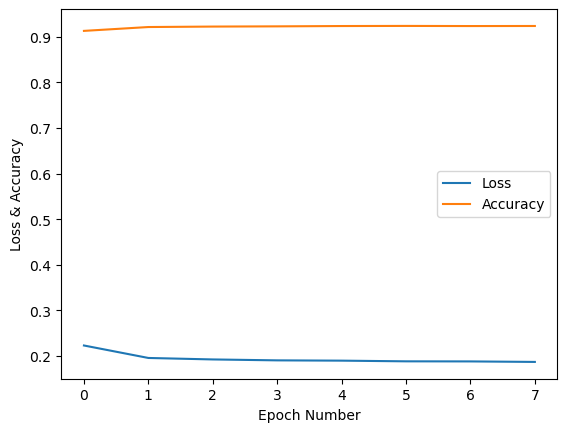

In [12]:
plt.xlabel("Epoch Number")
plt.ylabel("Loss & Accuracy")
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["accuracy"], label="Accuracy")
plt.legend()
plt.show()

### 📖Evaluate on validation data
Notice that the accuracy here is lower than the accuracy plotted during training! The accuracy that is plotted during training is only based on the training data. This time it is based on testing data

In [13]:
model.evaluate(x_test, y_test)

2683/2683 [==============================] - 2s 679us/step - loss: 0.2339 - accuracy: 0.9018


[0.2339036911725998, 0.9017590880393982]

### 📖Predict some data

In [14]:
observation = 14 #14
print(f"Real class: {y_test[observation]}")
print(f"Input features: {x_test[observation]}")

Real class: 1
Input features: [ 0.1145      0.0956      0.1084      0.1851      0.14196876  0.088775
 -0.1318721   0.08995716  0.31884575  0.2613288 ]


In [16]:
#If we want to predict a single datapoint from our testing data,
#we need to reshape the data that we put into our trained model. 
#Here is an example of the difference between the data and the reshaped data
print(x_test[observation,:].shape)
print(x_test[observation,:].reshape(1,-1).shape)

(10,)
(1, 10)


In [17]:
model.predict(x_test[observation].reshape(1, -1))

1/1 [==============================] - 0s 80ms/step


array([[0.90219915]], dtype=float32)

### 📖Predict all test data

In [18]:
y_test_pred = model.predict(x_test)
y_test_pred = y_test_pred.reshape(290, 296)

2683/2683 [==============================] - 2s 632us/step


### 📖Turn y_test_pred into image

In [ ]:
tiff.imwrite("ProbabilityMap.tif", y_test_pred)
#tiff.imwrite("y_test_NoCRS.tif", y_test)